In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Auxiliary Functions

In [ ]:
def retrieve_data(path,interval,npoints,sufix=""):
  dfTrain = pd.DataFrame()
  dfTest = pd.DataFrame()
  for idx in range(npoints):
    df = pd.read_csv(path+'train'+str(idx)+'_'+str(interval)+sufix+'.csv',index_col=0)
    df['batch_index'] = idx
    dfTrain = pd.concat([dfTrain, df], ignore_index=True)
  for idx in range(npoints):
    df = pd.read_csv(path+'test'+str(idx)+'_'+str(interval)+sufix+'.csv',index_col=0)
    df['batch_index'] = idx
    dfTest = pd.concat([dfTest, df], ignore_index=True)
  dfAccTrain = pd.read_csv(path+'train_accuracy_'+str(interval)+sufix+'.csv',index_col=0)
  dfAccTest = pd.read_csv(path+'test_accuracy_'+str(interval)+sufix+'.csv',index_col=0)
  return dfTrain,dfTest,dfAccTrain,dfAccTest

def format_data(dfTrain,dfTest,dfAccTrain,dfAccTest,in_percentage=True):
  dfTrain["epoch"] +=1
  dfTest["epoch"] +=1
  dfAccTrain["epoch"] +=1
  dfAccTest["epoch"] +=1

  for epoch in dfTrain["epoch"].unique():
    for batch_index in dfTrain["batch_index"].unique():
      for metric in dfTrain["metric"].unique():
        newDf = pd.DataFrame({"epoch":epoch, "layer":"e2e","metric":metric,"batch_index":batch_index,"value":np.nan},index=[0])
        dfTrain = pd.concat([dfTrain,newDf],ignore_index=True,axis=0)
        dfTest = pd.concat([dfTest,newDf],ignore_index=True,axis=0)

  dfAccTrainFormat = dfTrain.copy(deep=True)
  dfAccTrainFormat["value"] = np.nan
  for _,r in dfAccTrain.iterrows():
    dfAccTrainFormat.loc[(dfAccTrainFormat["epoch"]==r['epoch']) & (dfAccTrainFormat["layer"]=='e2e'),'value'] = 1- r['value']

  dfAccTestFormat = dfTest.copy(deep=True)
  dfAccTestFormat["value"] = np.nan
  for _,r in dfAccTest.iterrows():
    dfAccTestFormat.loc[(dfAccTestFormat["epoch"]==r['epoch']) & (dfAccTestFormat["layer"]=='e2e'),'value'] = 1- r['value']

  if in_percentage:
    dfTrain['value'] = 100*dfTrain['value']
    dfTest['value'] = 100*dfTest['value']
    dfAccTrainFormat['value'] = 100*dfAccTrainFormat['value']
    dfAccTestFormat['value'] = 100*dfAccTestFormat['value']

  return dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat


In [ ]:
def plot_graphics(dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat,figsize,ylim,ylimAcc,legends,title="",remove_l1=True):
  palette_colors = sns.color_palette("Paired",len(dfTrain['epoch'].unique()))
  palette_dict = {epoch: color for epoch, color in zip(dfTrain['epoch'].unique(), palette_colors)}

  metrics = list(dfTrain['metric'].unique())
  if ('l1' in metrics) & remove_l1:
    metrics.remove('l1')

  nplots = len(metrics);
  fig, ax = plt.subplots(nplots,2,figsize=figsize)
  for i,metric in enumerate(metrics):
    ax1 = ax[0] if (nplots == 1) else ax[i,0]
    sns.lineplot(data=dfTrain[dfTrain.metric == metric],
                x="layer",y="value",hue="epoch", ax=ax1,
                err_style='bars',errorbar='sd',palette=palette_dict).set(title=legends[i][0],ylabel="complexity measure (%)")
    sns.move_legend(ax1, "lower left")
    ax1.set_ylim(100*ylim[i][0], 100*ylim[i][1])
    ax2 = ax1.twinx()
    sns.scatterplot(data=dfAccTrainFormat,y="value",x="layer",hue="epoch",marker="x",
                  palette=palette_dict,ax=ax2).set(ylabel="network error (%)")
    sns.move_legend(ax2, "lower left")
    ax2.set_ylim(ylimAcc[0],ylimAcc[1])

    ax1 = ax[1] if (nplots == 1) else ax[i,1]
    sns.lineplot(data=dfTest[dfTest.metric == metric],
               x="layer",y="value",hue="epoch",ax=ax1,
               err_style='bars',errorbar='sd',palette=palette_dict).set(title=legends[i][1],ylabel="complexity measure (%)")
    sns.move_legend(ax1, "lower left")
    ax1.set_ylim(100*ylim[i][0], 100*ylim[i][1])
    ax2 = ax1.twinx()
    sns.scatterplot(data=dfAccTestFormat,y="value",x="layer",hue="epoch",marker="x",
                  palette=palette_dict,ax=ax2).set(ylabel="network error (%)")
    sns.move_legend(ax2, "lower left")
    ax2.set_ylim(ylimAcc[0],ylimAcc[1])
  fig.suptitle(title, fontsize=30)
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])
  fig.show()

# LeNet5_MNIST

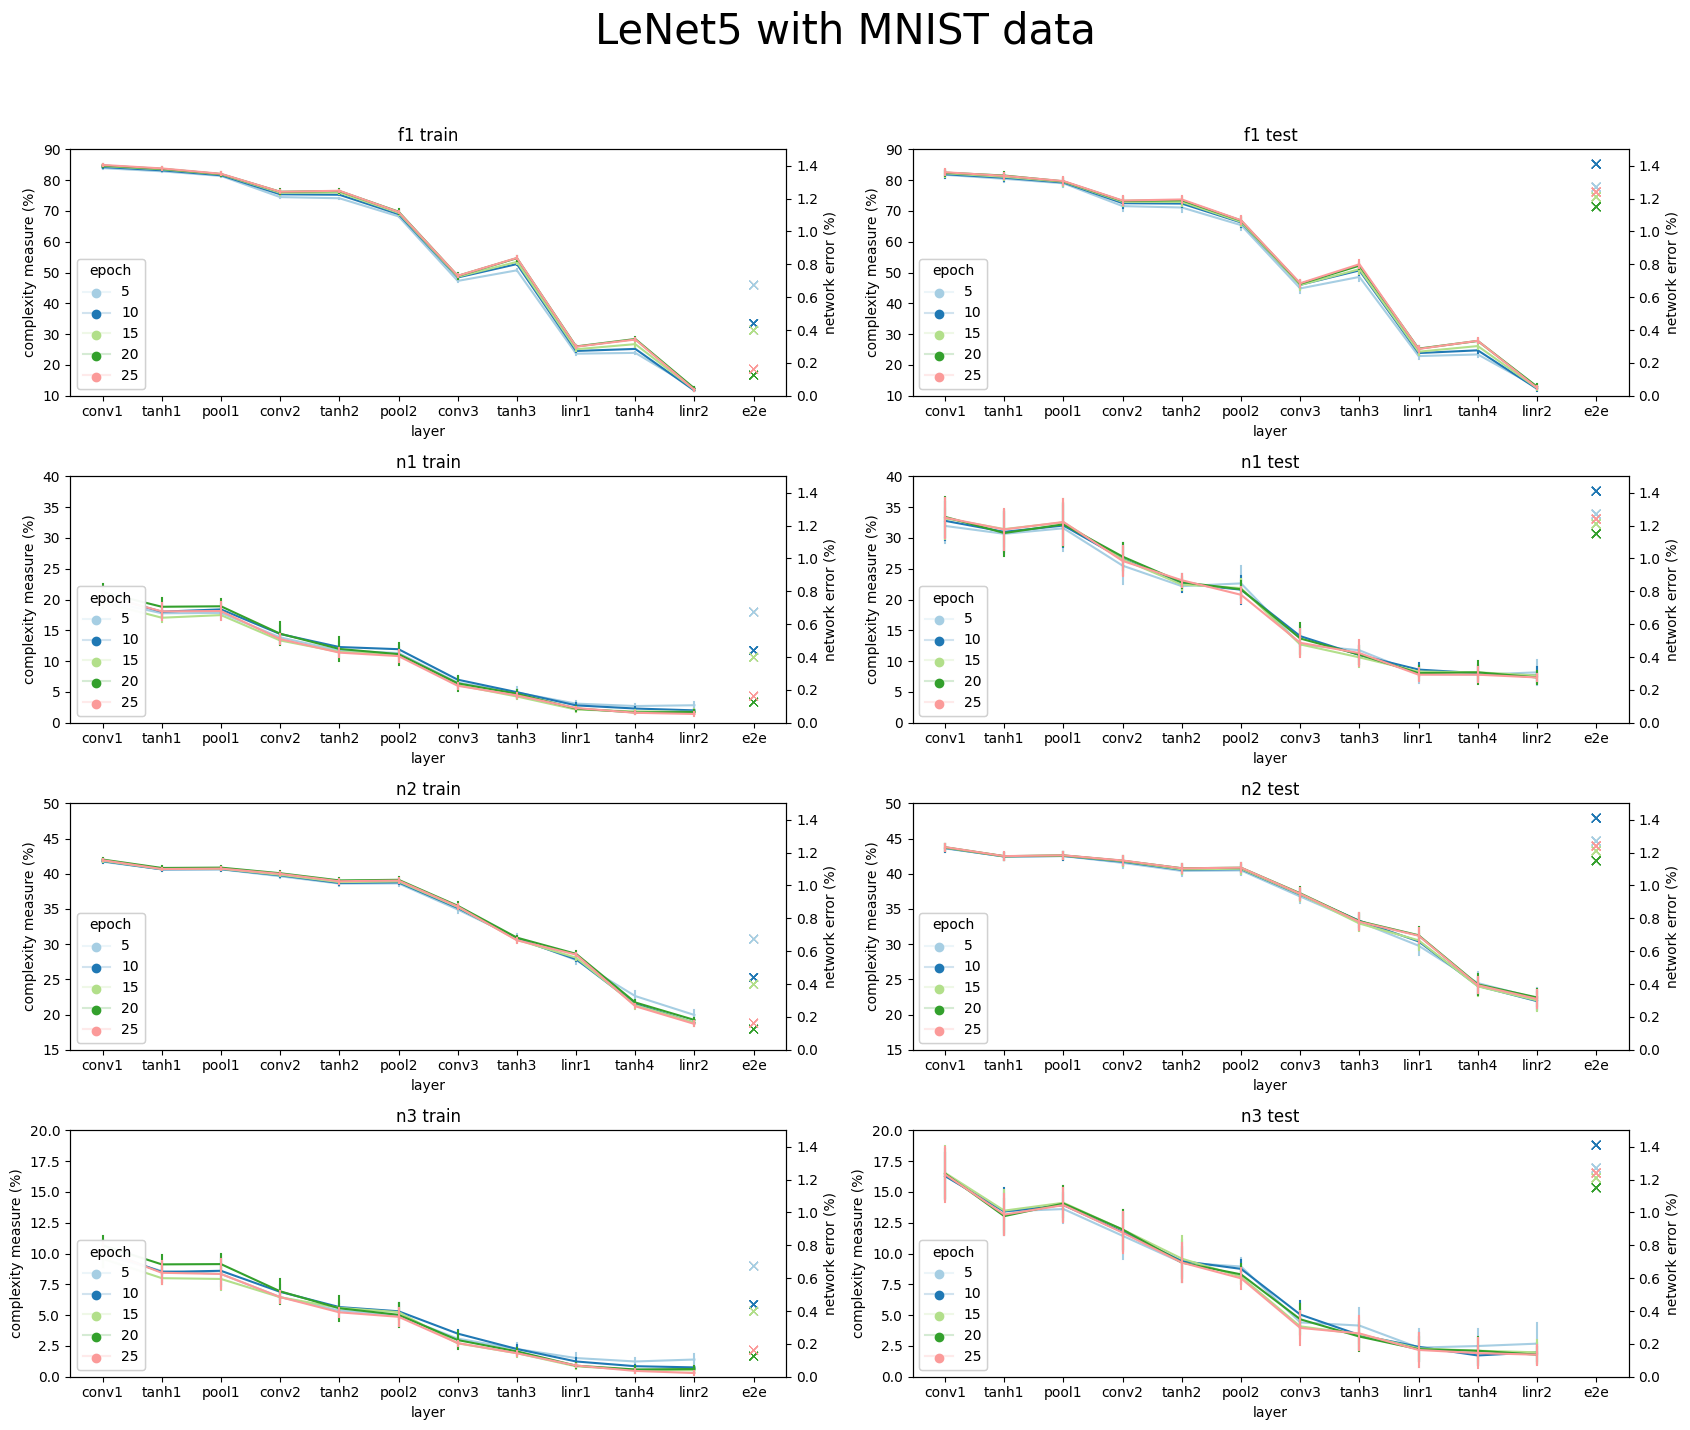

In [ ]:
dfTrain,dfTest,dfAccTrain,dfAccTest = retrieve_data('drive/MyDrive/TG/LeNet5_MNIST/',5,5)
dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat = format_data(dfTrain,dfTest,dfAccTrain,dfAccTest)

ylim=[[.1,.9], # f1
      # [-.0001,0.0002], #l1
      [.0,.4], #n1
      [.15,.5], #n2
      [.0,.2] #n3
      ]

ylimAcc=[.0,1.5]
legends = [["f1 train","f1 test"],
          #  ["l1 train","l1 test"],
           ["n1 train","n1 test"],
           ["n2 train","n2 test"],
           ["n3 train","n3 test"]]
figsize=(17,15)

plot_graphics(dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat,figsize,ylim,ylimAcc,legends,title="LeNet5 with MNIST data")
plt.savefig('LeNet5MNIST.png', bbox_inches='tight')

In [ ]:
3dfTrain = pd.DataFrame()
dfTest = pd.DataFrame()
for idx in range(5):
  df = pd.read_csv('drive/MyDrive/TG/LeNet5_MNIST/train'+str(idx)+'_5.csv',index_col=0)
  df['batch_index'] = idx
  dfTrain = pd.concat([dfTrain, df], ignore_index=True)
for idx in range(5):
  df = pd.read_csv('drive/MyDrive/TG/LeNet5_MNIST/test'+str(idx)+'_5.csv',index_col=0)
  df['batch_index'] = idx
  dfTest = pd.concat([dfTest, df], ignore_index=True)
dfAccTrain = pd.read_csv('drive/MyDrive/TG/LeNet5_MNIST/train_accuracy_5.csv',index_col=0)
dfAccTest = pd.read_csv('drive/MyDrive/TG/LeNet5_MNIST/test_accuracy_5.csv',index_col=0)
dfTest

In [ ]:
dfTrain["epoch"] +=1
dfTest["epoch"] +=1
dfAccTrain["epoch"] +=1
dfAccTest["epoch"] +=1

In [ ]:
df.pivot_table(index='layer', columns='metric', values='value',
         aggfunc=["sum", "mean"])

In [ ]:
for epoch in dfTrain["epoch"].unique():
  for batch_index in dfTrain["batch_index"].unique():
    for metric in dfTrain["metric"].unique():
      newDf = pd.DataFrame({"epoch":epoch, "layer":"acc","metric":metric,"batch_index":batch_index,"value":np.nan},index=[0])
      dfTrain = pd.concat([dfTrain,newDf],ignore_index=True,axis=0)

In [ ]:
dfTrain

In [ ]:
dfAccTrain

In [ ]:
dfAccTrainFormat = dfTrain.copy(deep=True)
dfAccTrainFormat["value"] = np.nan
for _,r in dfAccTrain.iterrows():
  dfAccTrainFormat.loc[(dfTrain["epoch"]==r['epoch']) & (dfTrain["layer"]=='acc'),'value'] = 1- r['value']
dfAccTrainFormat

In [ ]:
sns.scatterplot(data=dfAccTrainFormat,y="value",x="layer",hue="epoch",marker="x",loc='lower left')

In [ ]:
ylim=[[.1,.9], # f1
      [-.0001,0.0002], #l1
      [.0,.4], #n1
      [.15,.5], #n2
      [.0,.2] #n3
      ]
legends = [["f1 train","f1 test"],
           ["l1 train","l1 test"],
           ["n1 train","n1 test"],
           ["n2 train","n2 test"],
           ["n3 train","n3 test"]]

fig, ax =plt.subplots(5,2,figsize=(35,30))
for i,metric in enumerate(dfTrain['metric'].unique()):
  sns.lineplot(data=dfTrain[dfTrain.metric == metric],
               x="layer",y="value",hue="epoch", ax=ax[i,0],
               err_style='bars',errorbar='sd').set(title=legends[i][0])
  sns.move_legend(ax[i,0], "lower left")
  ax[i,0].set_ylim(ylim[i][0], ylim[i][1])
  ax2 = ax[i,0].twinx()
  sns.scatterplot(data=dfAccTrainFormat,y="value",x="layer",hue="epoch",marker="x",ax=ax2)
  # sns.lineplot(data=dfAccTrainFormat,y="value",x="layer",hue="epoch", marker="x",ax=ax2)
  # ax2.set_ylim(0,.01)
  sns.lineplot(data=dfTest[dfTest.metric == metric],
               x="layer",y="value",hue="epoch",ax=ax[i,1],
               err_style='bars',errorbar='sd').set(title=legends[i][1])
  ax[i,1].set_ylim(ylim[i][0], ylim[i][1])
fig.tight_layout()
fig.show()

# LeNet5_MNIST_Dropout

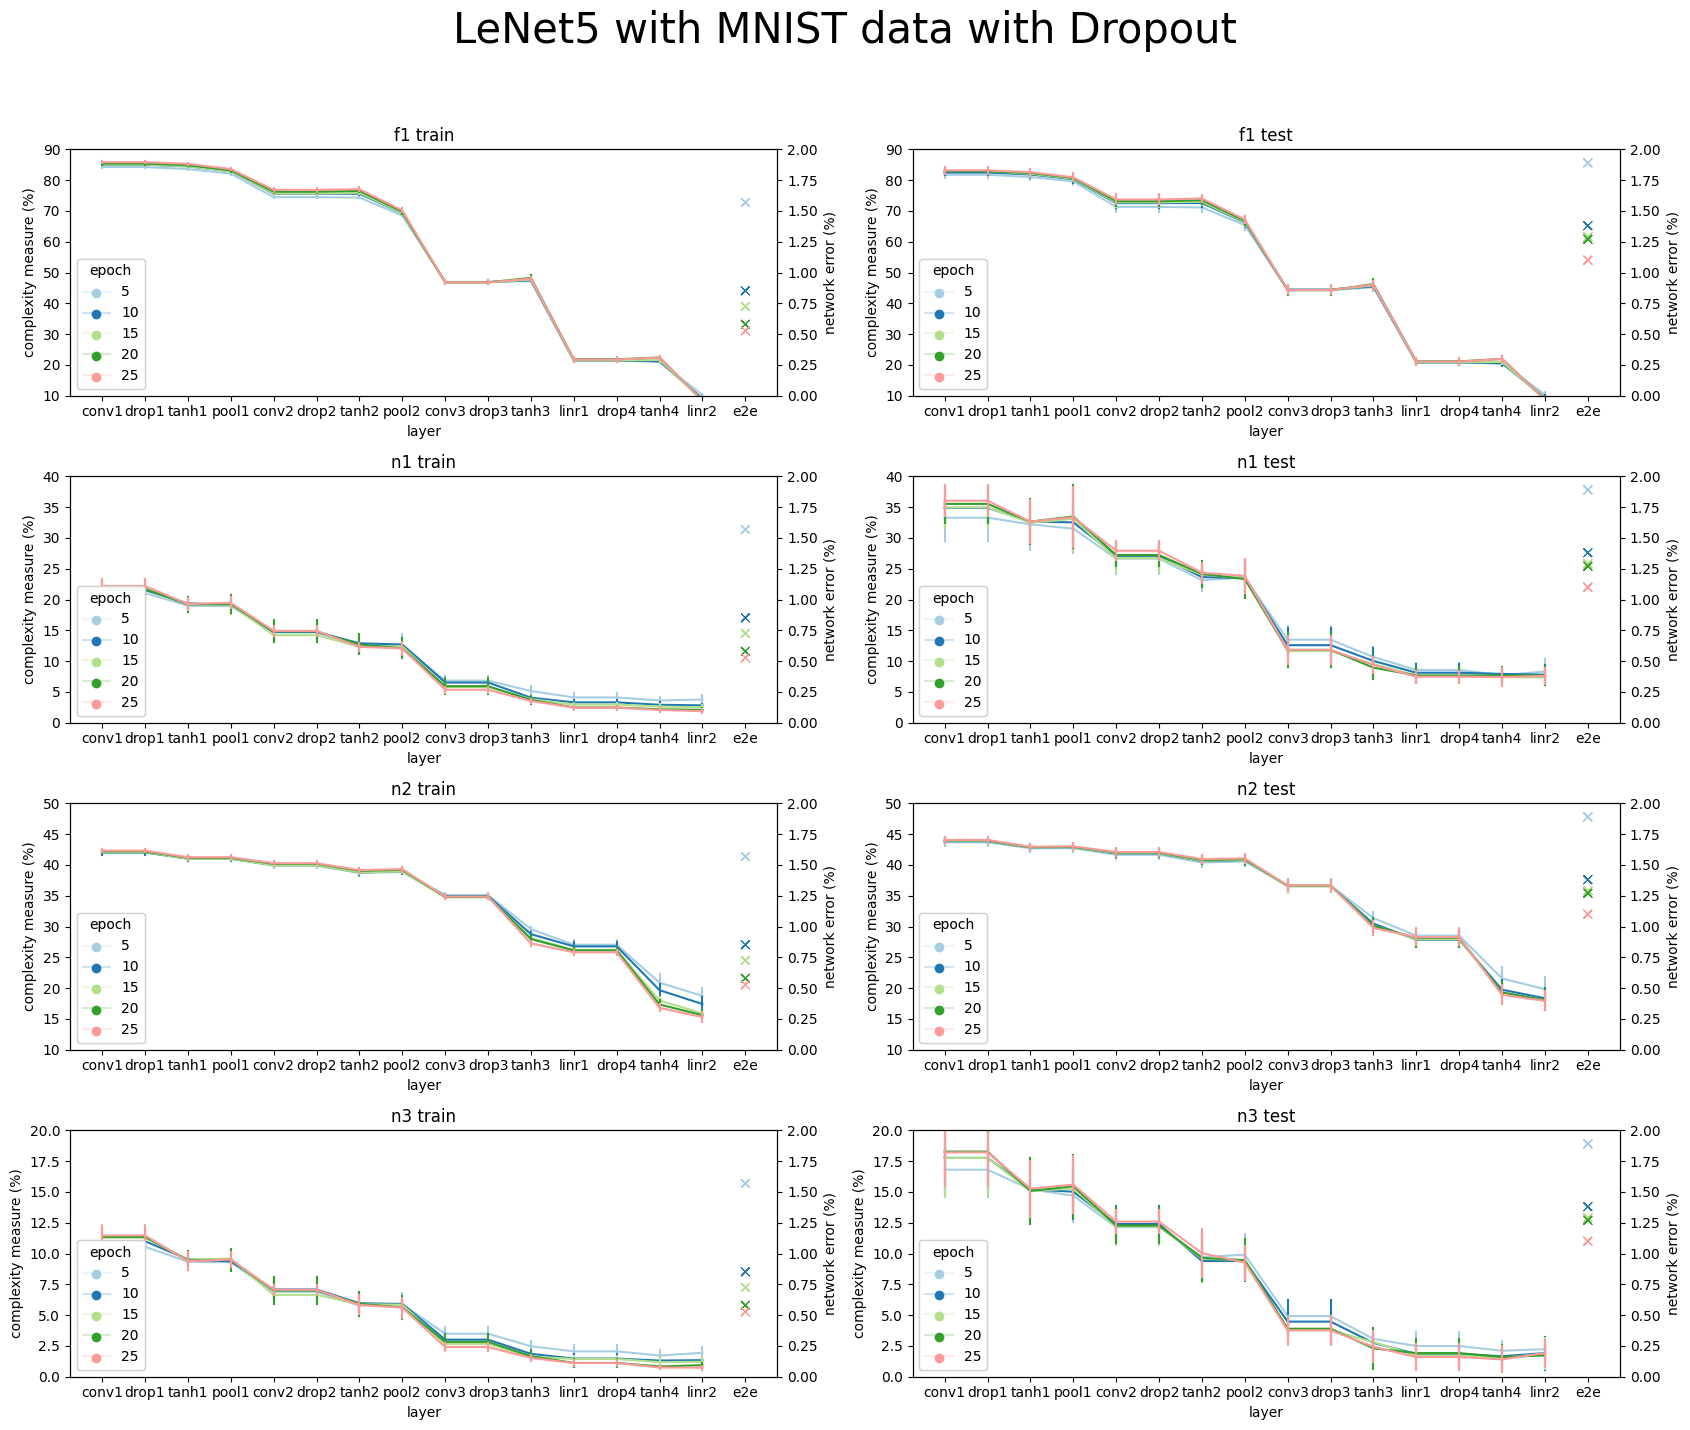

In [ ]:
dfTrain,dfTest,dfAccTrain,dfAccTest = retrieve_data('drive/MyDrive/TG/LeNet5_MNIST_Dropout/',5,5,sufix="_dropout")
dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat = format_data(dfTrain,dfTest,dfAccTrain,dfAccTest)

ylim=[[.1,.9], # f1
      # [-.0001,0.0006], #l1
      [.0,.4], #n1
      [.1,.5], #n2
      [.0,.2] #n3
      ]
ylimAcc=[.0,2.0]
legends = [["f1 train","f1 test"],
          #  ["l1 train","l1 test"],
           ["n1 train","n1 test"],
           ["n2 train","n2 test"],
           ["n3 train","n3 test"]]
figsize=(17,15)

plot_graphics(dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat,figsize,ylim,ylimAcc,legends,title="LeNet5 with MNIST data with Dropout")
plt.savefig('LeNetMNISTDropout.png', bbox_inches='tight')

In [ ]:
dfTrain = pd.DataFrame()
dfTest = pd.DataFrame()
for idx in range(5):
  df = pd.read_csv('drive/MyDrive/TG/LeNet5_MNIST_Dropout/train'+str(idx)+'_5_dropout.csv',index_col=0)
  df['batch_index'] = idx
  dfTrain = pd.concat([dfTrain, df], ignore_index=True)
for idx in range(5):
  df = pd.read_csv('drive/MyDrive/TG/LeNet5_MNIST_Dropout/test'+str(idx)+'_5_dropout.csv',index_col=0)
  df['batch_index'] = idx
  dfTest = pd.concat([dfTest, df], ignore_index=True)
dfTest

In [ ]:
dfTrain["epoch"] +=1
dfTest["epoch"] +=1

In [ ]:
ylim=[[.1,.9], # f1
      [-.0001,0.0006], #l1
      [.0,.4], #n1
      [.1,.5], #n2
      [.0,.2] #n3
      ]
legends = [["f1 train","f1 test"],
           ["l1 train","l1 test"],
           ["n1 train","n1 test"],
           ["n2 train","n2 test"],
           ["n3 train","n3 test"]]

fig, ax =plt.subplots(5,2,figsize=(28,13))

for i,metric in enumerate(dfTrain['metric'].unique()):
  sns.lineplot(data=dfTrain[dfTrain.metric == metric],
               x="layer",y="value",hue="epoch", ax=ax[i,0],
               err_style='bars',errorbar='sd').set(title=legends[i][0])
  ax[i,0].set_ylim(ylim[i][0], ylim[i][1])
  sns.lineplot(data=dfTest[dfTest.metric == metric],
               x="layer",y="value",hue="epoch",ax=ax[i,1],
               err_style='bars',errorbar='sd').set(title=legends[i][1])
  ax[i,1].set_ylim(ylim[i][0], ylim[i][1])
fig.tight_layout()
fig.show()

In [ ]:
dfTestFiltered = dfTest[~dfTest.layer.str.startswith('drop')]
dfTraintFiltered = dfTrain[~dfTrain.layer.str.startswith('drop')]
fig, ax =plt.subplots(5,2,figsize=(28,13))
for i,metric in enumerate(dfTrain['metric'].unique()):
  sns.lineplot(data=dfTraintFiltered[dfTraintFiltered.metric == metric],
               x="layer",y="value",hue="epoch", ax=ax[i,0],
               err_style='bars',errorbar='sd').set(title=legends[i][0])
  ax[i,0].set_ylim(ylim[i][0], ylim[i][1])
  sns.lineplot(data=dfTestFiltered[dfTestFiltered.metric == metric],
               x="layer",y="value",hue="epoch",ax=ax[i,1],
               err_style='bars',errorbar='sd').set(title=legends[i][1])
  ax[i,1].set_ylim(ylim[i][0], ylim[i][1])
fig.tight_layout()
fig.show()

In [ ]:
test = 'test'
test.startswith('tea')

In [ ]:
dfTest.layer.str.startswith('drop')

In [ ]:
sns.lineplot(data=dfTest,x="layer",y="value",hue="epoch")

#LeNet5_MNIST N3

In [ ]:
1-dfAccTest.iloc[0,1]

In [ ]:
dfTrain,dfTest,dfAccTrain,dfAccTest = retrieve_data('drive/MyDrive/TG/LeNet5_MNIST/',1,10)
dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat = format_data(dfTrain,dfTest,dfAccTrain,dfAccTest)

ylim=[[.0,.25] #n3
      ]
ylimAcc=[.0,3.5]
legends = [["n3 train","n3 test"]]
figsize=(20,10)

plot_graphics(dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat,figsize,ylim,ylimAcc,legends,title="LeNET5 N3 Metrics")
plt.savefig('LeNet5MNISTN3Tim.png', bbox_inches='tight')

In [ ]:
dfTrain = pd.DataFrame()
dfTest = pd.DataFrame()
for idx in range(10):
  df = pd.read_csv('drive/MyDrive/TG/LeNet5_MNIST/train'+str(idx)+'_1.csv',index_col=0)
  df['batch_index'] = idx
  dfTrain = pd.concat([dfTrain, df], ignore_index=True)
for idx in range(10):
  df = pd.read_csv('drive/MyDrive/TG/LeNet5_MNIST/test'+str(idx)+'_1.csv',index_col=0)
  df['batch_index'] = idx
  dfTest = pd.concat([dfTest, df], ignore_index=True)
dfTest

In [ ]:
dfTrain["epoch"] +=1
dfTest["epoch"] +=1

In [ ]:
ylim=[0,.22]
fig, ax =plt.subplots(1,2,figsize=(28,13))
sns.lineplot(data=dfTrain[dfTrain.metric == metric],
               x="layer",y="value",hue="epoch", ax=ax[0],
               err_style='bars',errorbar='sd').set(title="train")
ax[0].set_ylim(ylim[0], ylim[1])

sns.lineplot(data=dfTest[dfTest.metric == metric],
               x="layer",y="value",hue="epoch",ax=ax[1],
               err_style='bars',errorbar='sd').set(title="train")
ax[1].set_ylim(ylim[0], ylim[1])
fig.show()

#LeNet5_MNIST_Dropout N3

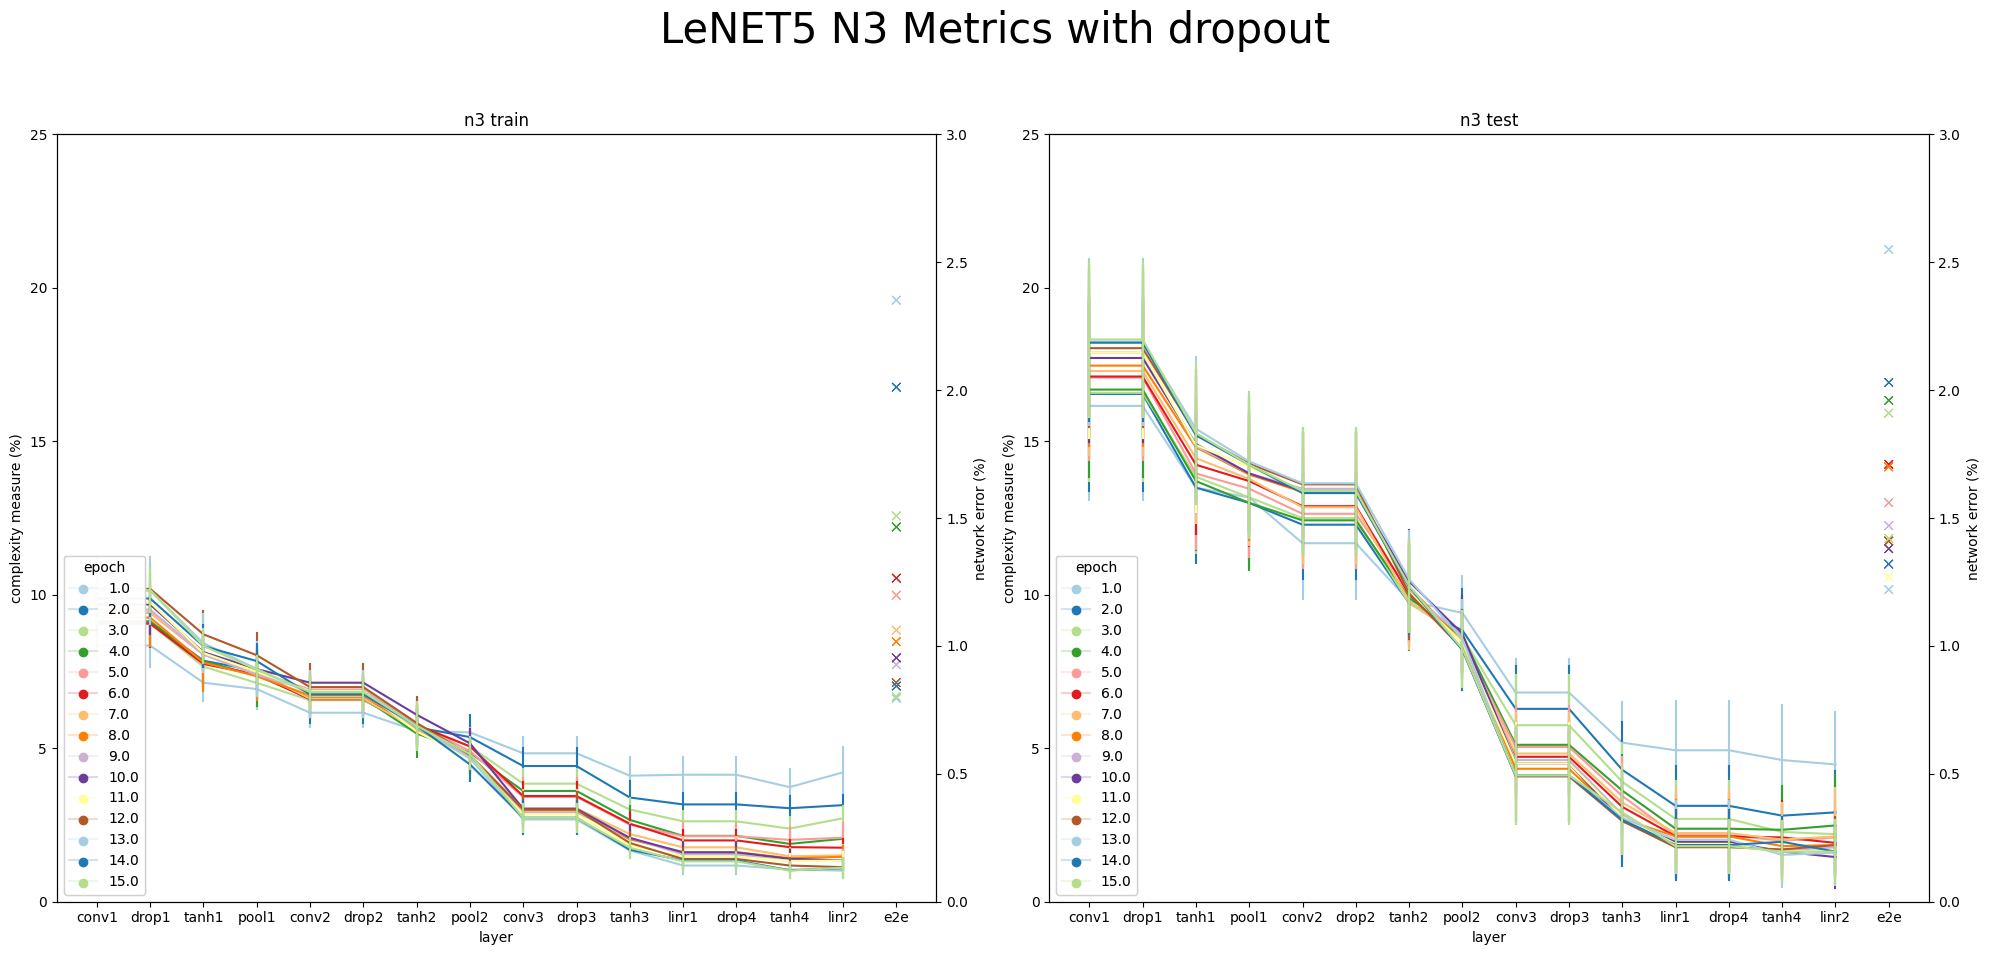

In [ ]:
dfTrain,dfTest,dfAccTrain,dfAccTest = retrieve_data('drive/MyDrive/TG/LeNet5_MNIST_Dropout/',1,10,sufix="_dropout")
dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat = format_data(dfTrain,dfTest,dfAccTrain,dfAccTest)

ylim=[[.0,.25] #n3
      ]
ylimAcc=[.0,3]
legends = [["n3 train","n3 test"]]
figsize=(20,10)

plot_graphics(dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat,figsize,ylim,ylimAcc,legends,title="LeNET5 N3 Metrics with dropout")
plt.savefig('LeNet5DropoutMNISTN3Tim.png', bbox_inches='tight')

In [ ]:
dfTrain = pd.DataFrame()
dfTest = pd.DataFrame()
for idx in range(10):
  df = pd.read_csv('drive/MyDrive/TG/LeNet5_MNIST_Dropout/train'+str(idx)+'_1_dropout.csv',index_col=0)
  df['batch_index'] = idx
  dfTrain = pd.concat([dfTrain, df], ignore_index=True)
for idx in range(10):
  df = pd.read_csv('drive/MyDrive/TG/LeNet5_MNIST_Dropout/test'+str(idx)+'_1_dropout.csv',index_col=0)
  df['batch_index'] = idx
  dfTest = pd.concat([dfTest, df], ignore_index=True)
dfTest

In [ ]:
dfTrain["epoch"] +=1
dfTest["epoch"] +=1

In [ ]:
dfTrain.metric

In [ ]:
ylim=[0,.22]
fig, ax =plt.subplots(1,2,figsize=(28,13))
sns.lineplot(data=dfTrain[dfTrain.metric == 'n3'],
               x="layer",y="value",hue="epoch", ax=ax[0],
               err_style='bars',errorbar='sd').set(title='n3 = mfe.ft_n3(X, y,metric=\'minkowski\')')
ax[0].set_ylim(ylim[0], ylim[1])
sns.lineplot(data=dfTest[dfTest.metric == 'n3'],
               x="layer",y="value",hue="epoch",ax=ax[1],
               err_style='bars',errorbar='sd').set(title='n3 = mfe.ft_n3(X, y,metric=\'minkowski\')')
ax[1].set_ylim(ylim[0], ylim[1])
fig.show()

# LeNet5_Cifar100_Vehicles2

In [ ]:
metric = 'n3'
print(min(dfTrain[dfTrain['metric']==metric]['value']))
print(max(dfTrain[dfTrain['metric']==metric]['value']))
print(min(dfTest[dfTest['metric']==metric]['value']))
print(max(dfTest[dfTest['metric']==metric]['value']))

29.11392405063291
74.68354430379746
43.75
75.0


/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarn

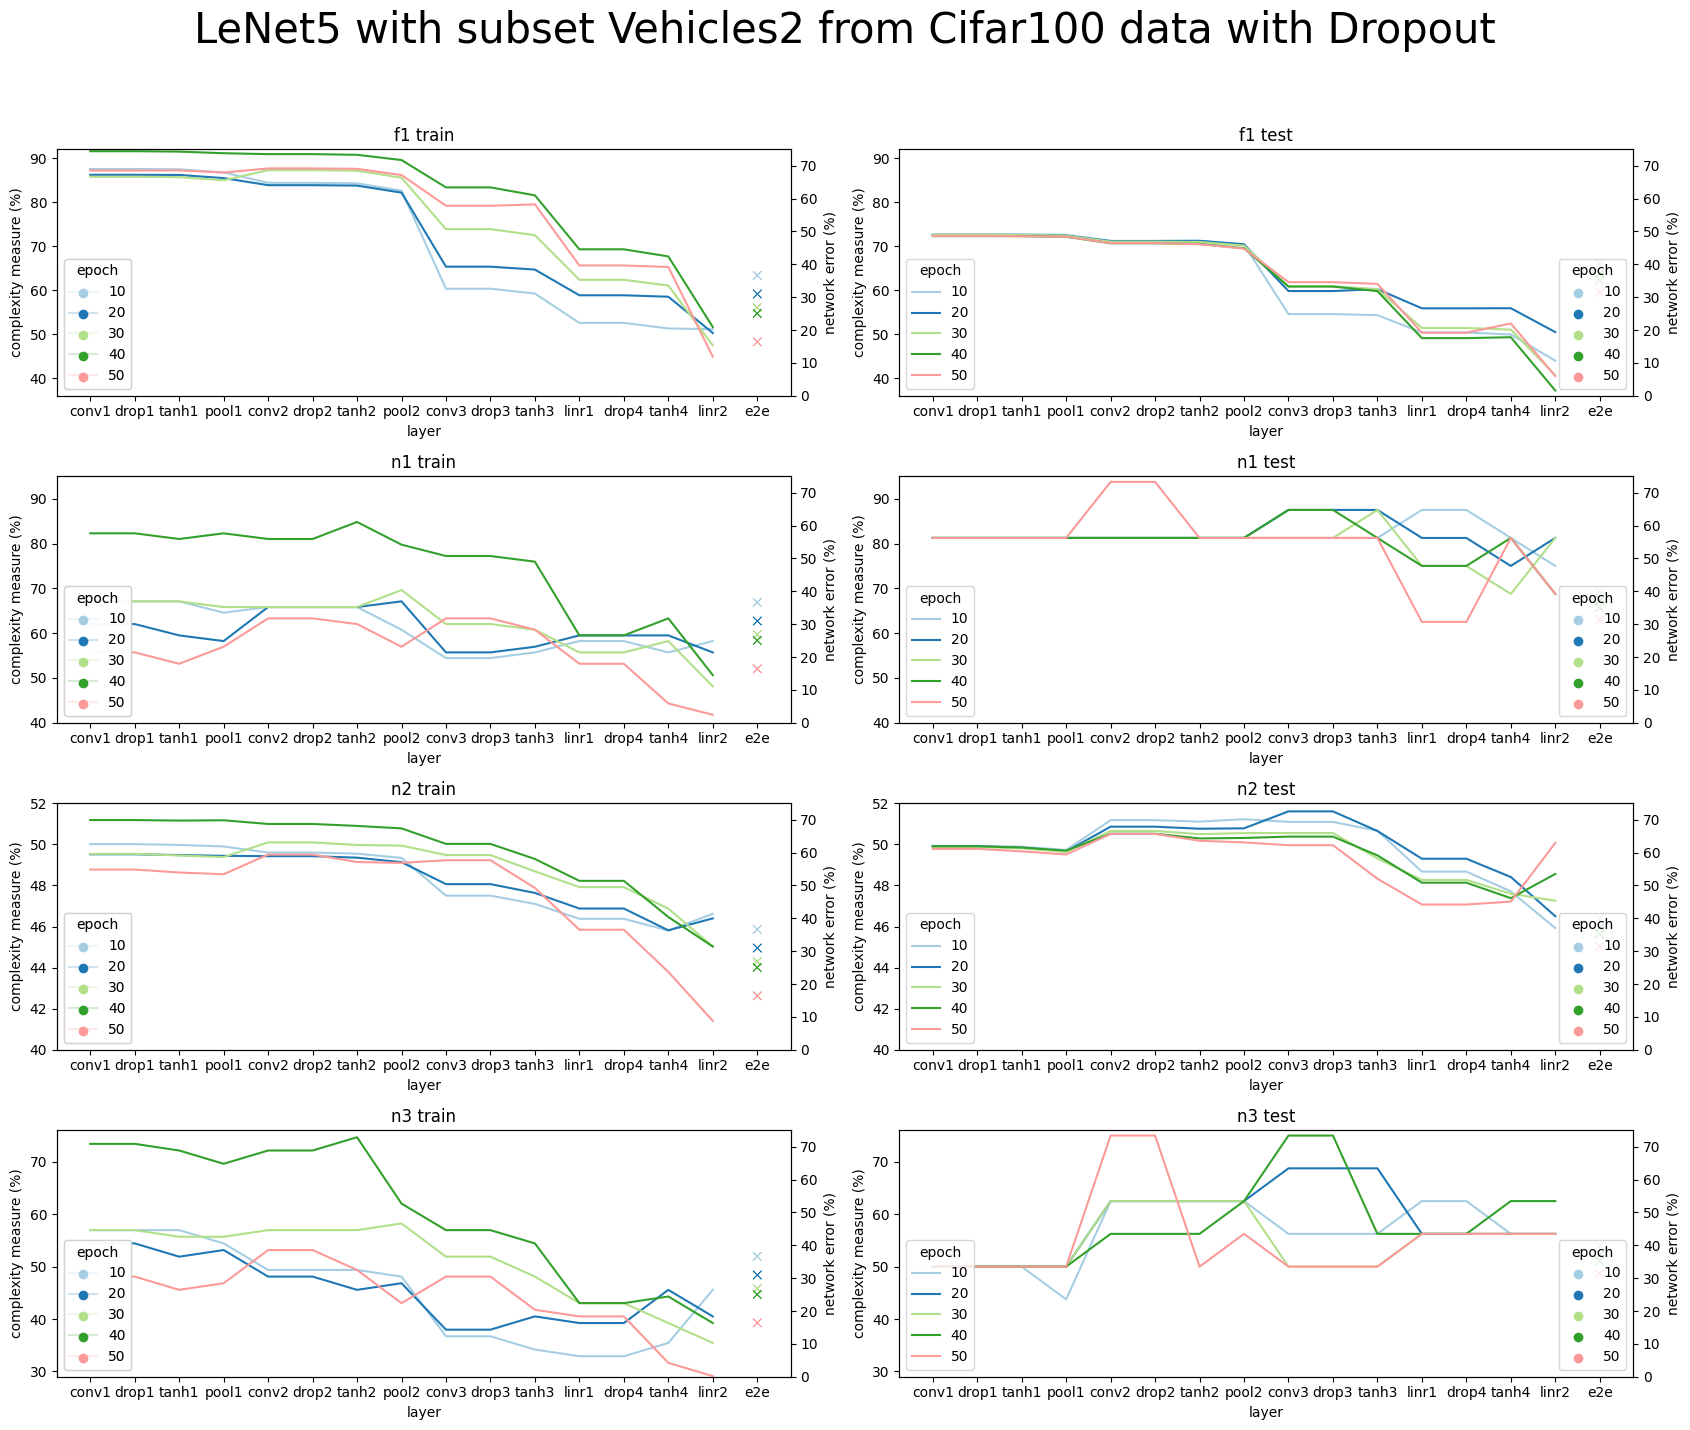

In [ ]:
dfTrain,dfTest,dfAccTrain,dfAccTest = retrieve_data('drive/MyDrive/TG/LeNet5_Cifar100_Vehicles2/',10,1,sufix='_dropout_cifar100_vehicles2')
dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat = format_data(dfTrain,dfTest,dfAccTrain,dfAccTest)

ylim=[[.36,.92], # f1
      # [-.0001,0.0002], #l1
      [.40,.95], #n1
      [.40,.52], #n2
      [.29,.76] #n3
      ]

ylimAcc=[.0,75]
legends = [["f1 train","f1 test"],
          #  ["l1 train","l1 test"],
           ["n1 train","n1 test"],
           ["n2 train","n2 test"],
           ["n3 train","n3 test"]]
figsize=(17,15)

plot_graphics(dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat,figsize,ylim,ylimAcc,legends,title="LeNet5 with subset Vehicles2 from Cifar100 data with Dropout")
plt.savefig('LeNetCifar100Vehicles2Dropout.png', bbox_inches='tight')


In [ ]:
dfTrain = pd.DataFrame()
dfTest = pd.DataFrame()
for idx in range(1):
  df = pd.read_csv('drive/MyDrive/TG/LeNet5_Cifar100_Vehicles2/train'+str(idx)+'_5_dropout_cifar100_vehicles2.csv',index_col=0)
  df['batch_index'] = idx
  dfTrain = pd.concat([dfTrain, df], ignore_index=True)
for idx in range(1):
  df = pd.read_csv('drive/MyDrive/TG/LeNet5_Cifar100_Vehicles2/test'+str(idx)+'_5_dropout_cifar100_vehicles2.csv',index_col=0)
  df['batch_index'] = idx
  dfTest = pd.concat([dfTest, df], ignore_index=True)
dfTest

In [ ]:
dfTrain["epoch"] +=1
dfTest["epoch"] +=1

In [ ]:
ylim=[[.1,.9], # f1
      [-.0001,0.0002], #l1
      [.3,.7], #n1
      [.3,.7], #n2
      [.3,.7] #n3
      ]
legends = [["f1 train","f1 test"],
           ["l1 train","l1 test"],
           ["n1 train","n1 test"],
           ["n2 train","n2 test"],
           ["n3 train","n3 test"]]

fig, ax =plt.subplots(5,2,figsize=(28,13))
for i,metric in enumerate(dfTrain['metric'].unique()):
  sns.lineplot(data=dfTrain[dfTrain.metric == metric],
               x="layer",y="value",hue="epoch", ax=ax[i,0],
               err_style='bars',errorbar='sd').set(title=legends[0])
  # ax[i,0].set_ylim(ylim[i][0], ylim[i][1])
  sns.lineplot(data=dfTest[dfTest.metric == metric],
               x="layer",y="value",hue="epoch",ax=ax[i,1],
               err_style='bars',errorbar='sd').set(title=legends[1])
  # ax[i,1].set_ylim(ylim[i][0], ylim[i][1])
fig.show()

# LeNet5_Cifar100_People



In [ ]:
metric = 'n3'
print(min(dfTrain[dfTrain['metric']==metric]['value']))
print(max(dfTrain[dfTrain['metric']==metric]['value']))
print(min(dfTest[dfTest['metric']==metric]['value']))
print(max(dfTest[dfTest['metric']==metric]['value']))

45.56962025316455
81.0126582278481
50.0
100.0


/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:1185: RuntimeWarn

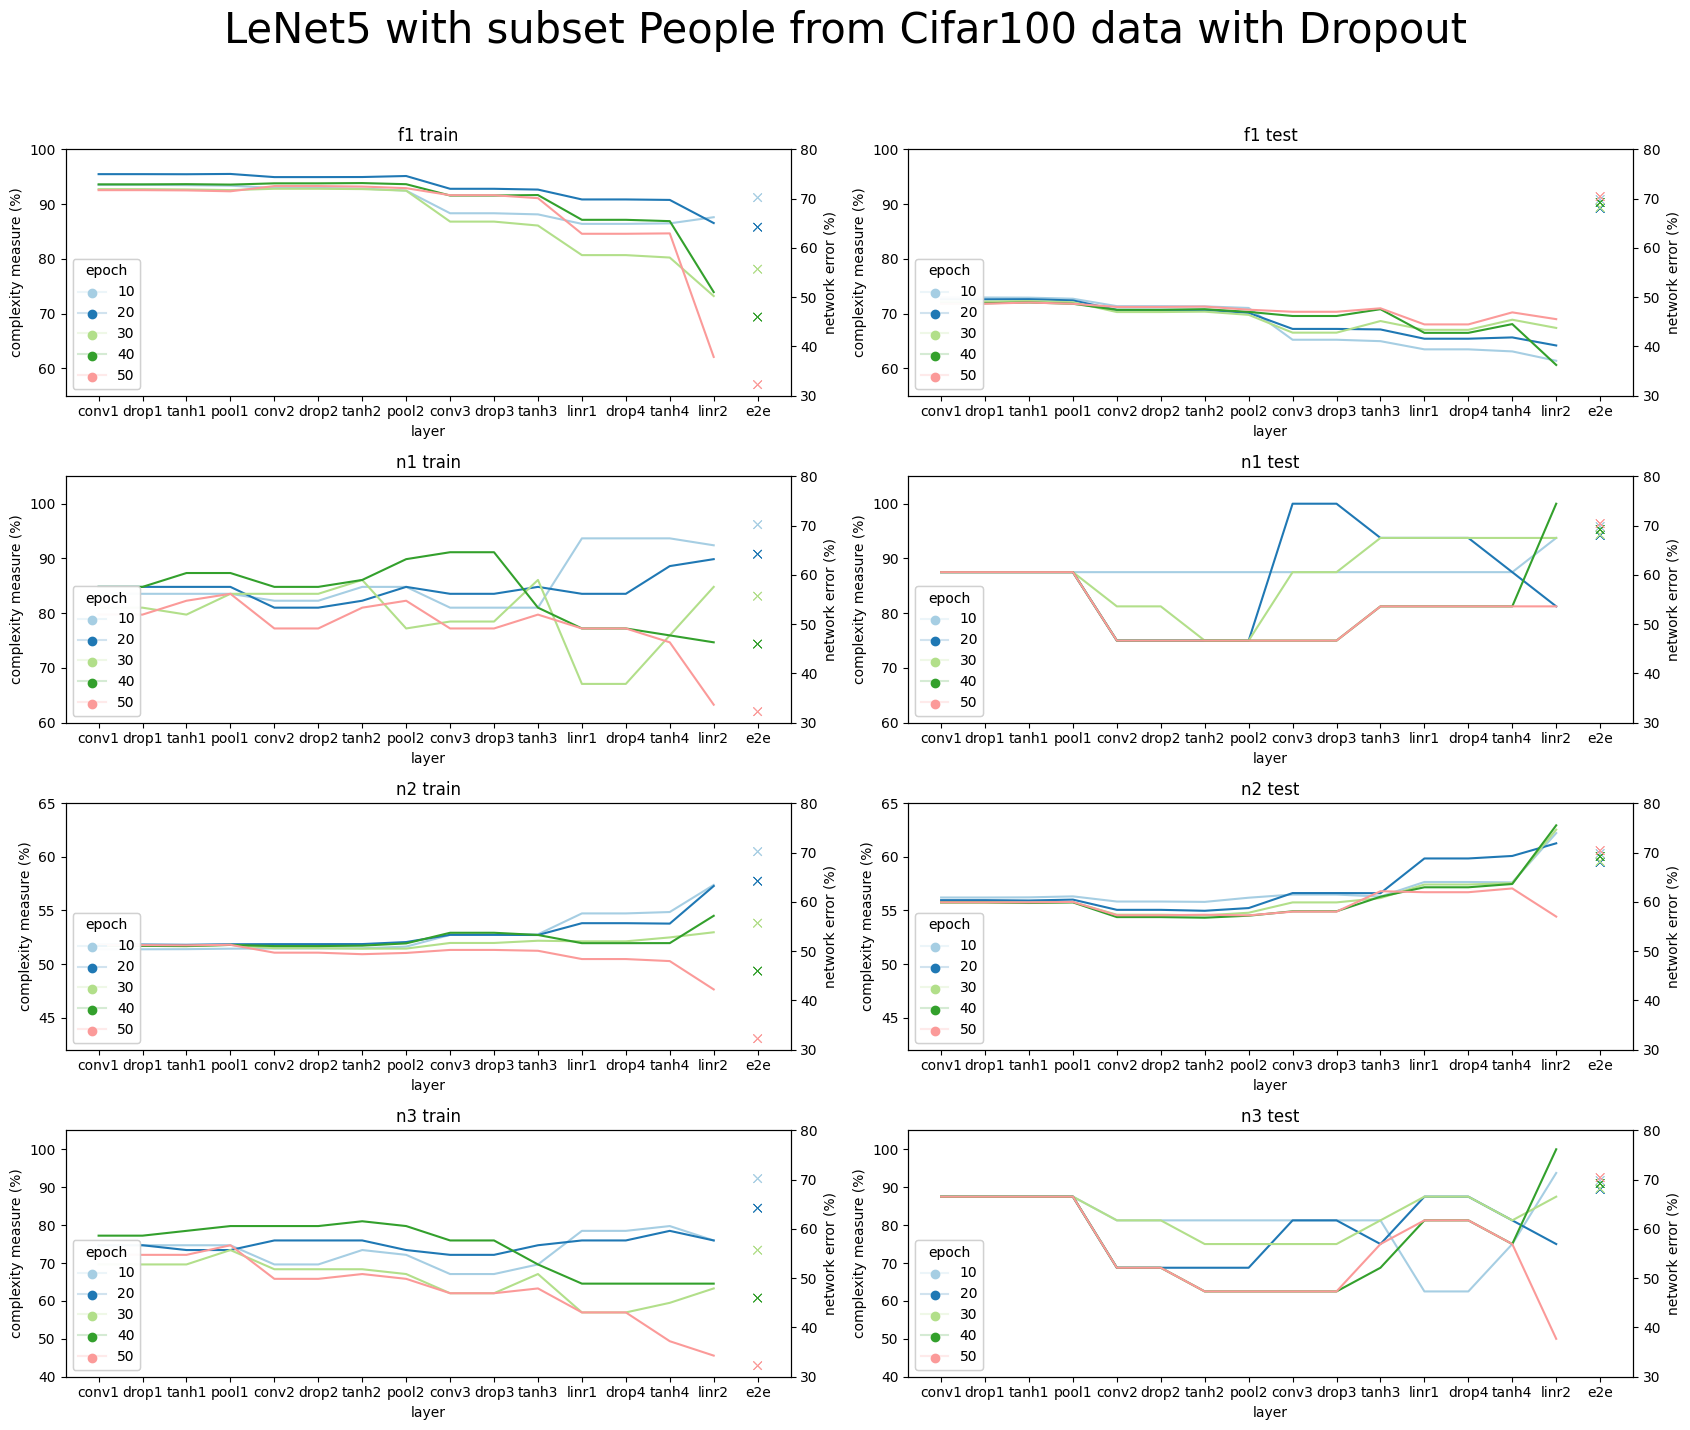

In [ ]:
dfTrain,dfTest,dfAccTrain,dfAccTest = retrieve_data('drive/MyDrive/TG/LeNet5_Cifar100_People/',10,1,sufix='_dropout_cifar100_people')
dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat = format_data(dfTrain,dfTest,dfAccTrain,dfAccTest)

ylim=[[.55,1], # f1
      # [-.0001,0.0002], #l1
      [.6,1.05], #n1
      [.42,.65], #n2
      [.40,1.05] #n3
      ]

ylimAcc=[30,80]
legends = [["f1 train","f1 test"],
          #  ["l1 train","l1 test"],
           ["n1 train","n1 test"],
           ["n2 train","n2 test"],
           ["n3 train","n3 test"]]
figsize=(17,15)

plot_graphics(dfTrain,dfTest,dfAccTrainFormat,dfAccTestFormat,figsize,ylim,ylimAcc,legends,title="LeNet5 with subset People from Cifar100 data with Dropout")
plt.savefig('LeNetCifar100PeopleDropout.png', bbox_inches='tight')

In [ ]:
dfTrain = pd.DataFrame()
dfTest = pd.DataFrame()
for idx in range(1):
  df = pd.read_csv('drive/MyDrive/TG/LeNet5_Cifar100_People/train'+str(idx)+'_5_dropout_cifar100_people.csv',index_col=0)
  df['batch_index'] = idx
  dfTrain = pd.concat([dfTrain, df], ignore_index=True)
for idx in range(1):
  df = pd.read_csv('drive/MyDrive/TG/LeNet5_Cifar100_People/test'+str(idx)+'_5_dropout_cifar100_people.csv',index_col=0)
  df['batch_index'] = idx
  dfTest = pd.concat([dfTest, df], ignore_index=True)
dfTest

In [ ]:
fig, ax =plt.subplots(5,2,figsize=(28,13))
for i,metric in enumerate(dfTrain['metric'].unique()):
  sns.lineplot(data=dfTrain[dfTrain.metric == metric],
               x="layer",y="value",hue="epoch", ax=ax[i,0],
               err_style='bars',errorbar='sd')
  ax[i,0].set_ylim(0, 1)
  sns.lineplot(data=dfTest[dfTest.metric == metric],
               x="layer",y="value",hue="epoch",ax=ax[i,1],
               err_style='bars',errorbar='sd')
  ax[i,1].set_ylim(0, 1)
fig.show()

# Accuracy

In [ ]:
def retrieve_acc_data(path,interval,nepochs,sufix=""):
  dfAccTrain = pd.read_csv(path+'train_accuracy_'+str(interval)+'_'+str(nepochs)+sufix+'.csv',index_col=0)
  dfAccTest = pd.read_csv(path+'test_accuracy_'+str(interval)+'_'+str(nepochs)+sufix+'.csv',index_col=0)
  dfAccTrain["epoch"] +=1
  dfAccTest["epoch"] +=1
  dfAccTrain["value"] *= 100
  dfAccTest["value"] *= 100
  return dfAccTrain,dfAccTest

def plot_acc(dfAccTrain,dfAccTest,figsize,ylimAcc,title=""):
  fig, ax = plt.subplots(figsize=figsize)
  concatenated = pd.concat([dfAccTrain.assign(dataset='train'), dfAccTest.assign(dataset='test')])
  ax = sns.lineplot(data=concatenated,x='epoch',y='value',hue='dataset').set(ylabel='accuracy (%)')
  fig.suptitle(title, fontsize=20)

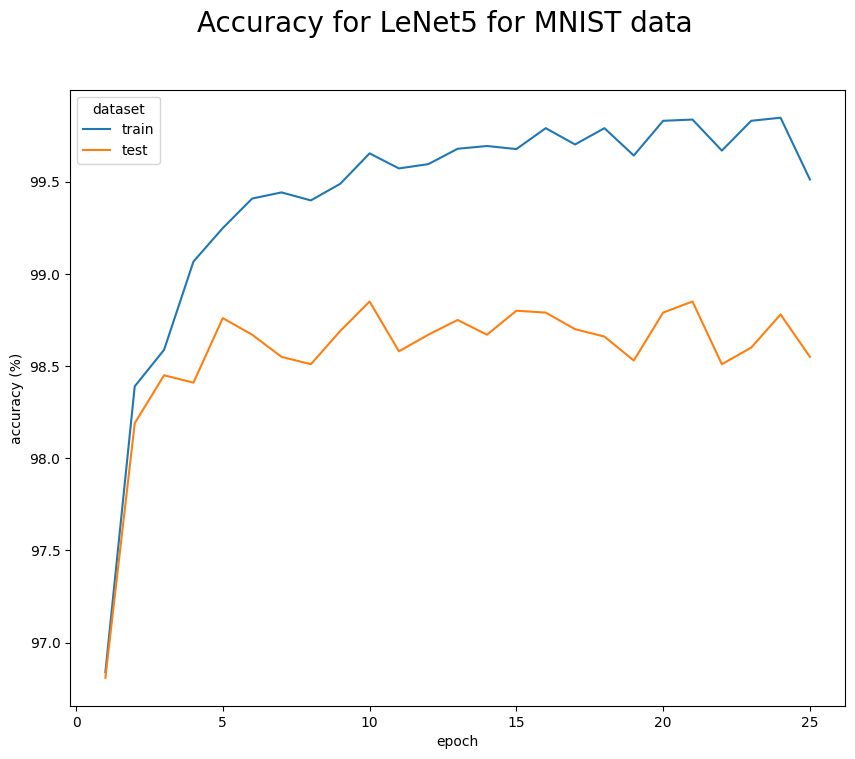

In [ ]:
figsize=(10,8)
ylimAcc=[.0,1.5]
dfAccTrain,dfAccTest = retrieve_acc_data('drive/MyDrive/TG/LeNet5_MNIST/',1,25)
plot_acc(dfAccTrain,dfAccTest,figsize,ylimAcc,title="Accuracy for LeNet5 for MNIST data")
plt.savefig('AccLeNet5MNIST.png', bbox_inches='tight')

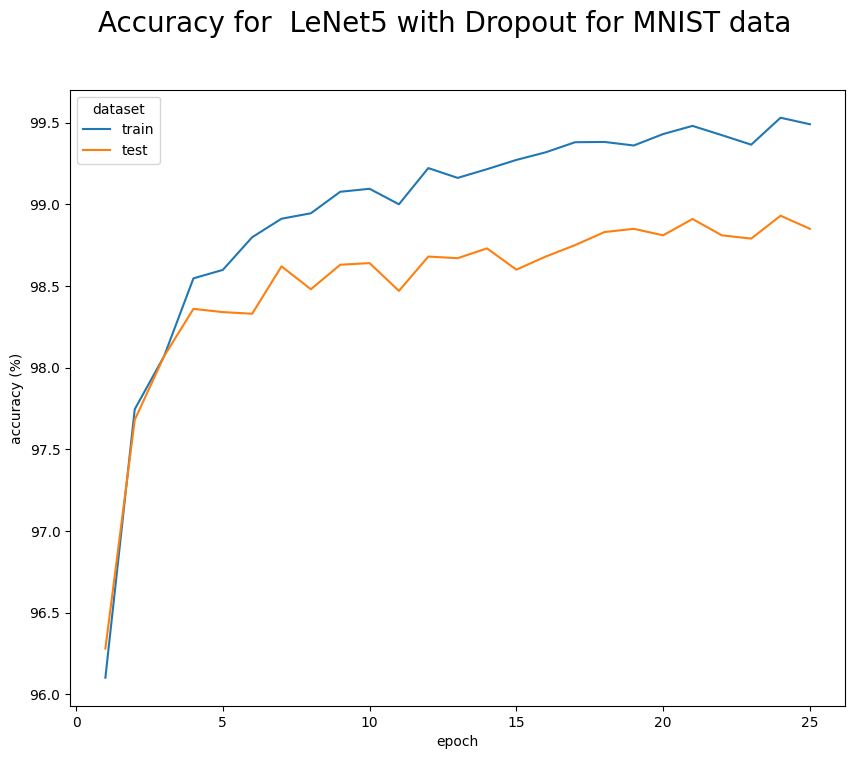

In [ ]:
figsize=(10,8)
ylimAcc=[.0,1.5]
dfAccTrain,dfAccTest = retrieve_acc_data('drive/MyDrive/TG/LeNet5_MNIST_Dropout/',1,25,sufix='_dropout')
plot_acc(dfAccTrain,dfAccTest,figsize,ylimAcc,title="Accuracy for  LeNet5 with Dropout for MNIST data")
plt.savefig('AccLeNet5DropoutMNIST.png', bbox_inches='tight')

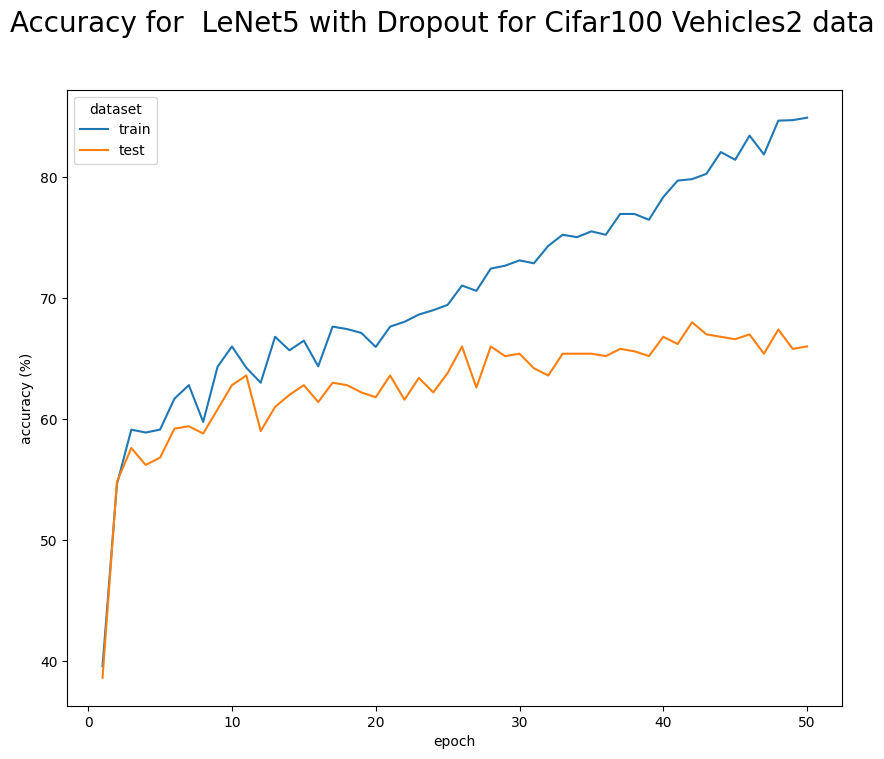

In [ ]:
figsize=(10,8)
ylimAcc=[.0,1.5]
dfAccTrain,dfAccTest = retrieve_acc_data('drive/MyDrive/TG/LeNet5_Cifar100_Vehicles2/',1,50,sufix='_dropout_cifar100_vehicles2')
plot_acc(dfAccTrain,dfAccTest,figsize,ylimAcc,title="Accuracy for  LeNet5 with Dropout for Cifar100 Vehicles2 data")
plt.savefig('AccLeNet5DropoutCifar100Vehicles2.png', bbox_inches='tight')

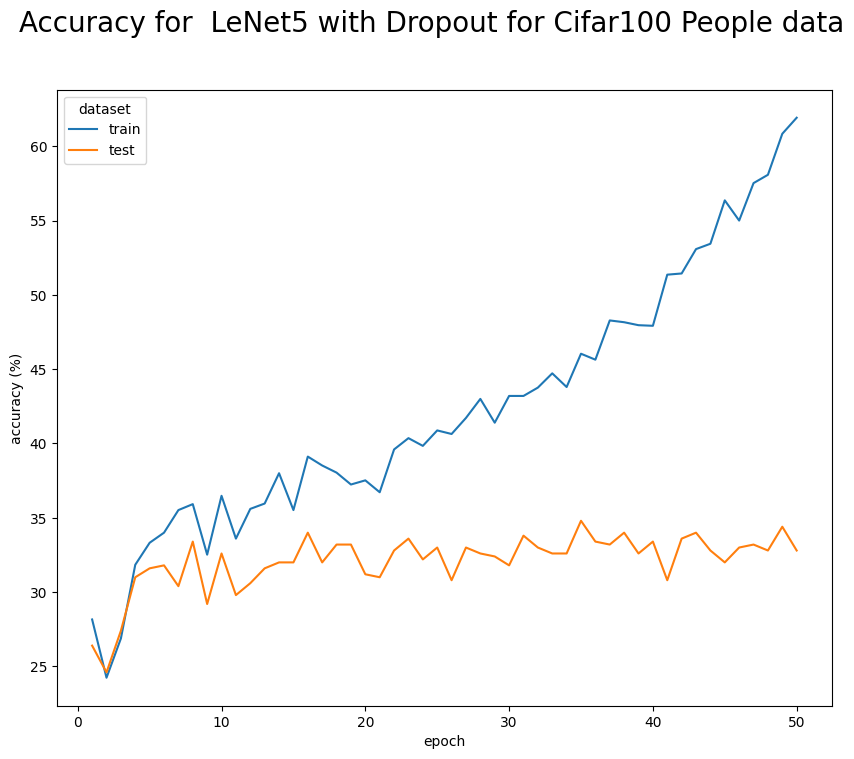

In [ ]:
figsize=(10,8)
ylimAcc=[.0,1.5]
dfAccTrain,dfAccTest = retrieve_acc_data('drive/MyDrive/TG/LeNet5_Cifar100_People/',1,50,sufix='_dropout_cifar100_people')
plot_acc(dfAccTrain,dfAccTest,figsize,ylimAcc,title="Accuracy for  LeNet5 with Dropout for Cifar100 People data")
plt.savefig('AccLeNet5DropoutCifar100People.png', bbox_inches='tight')

In [ ]:
# concatenated = pd.concat([dfAccTrain.assign(dataset='train'), dfAccTest.assign(dataset='test')])
# ax = sns.lineplot(data=concatenated,x='epoch',y='value',hue='dataset')
# ax2 = ax.twinx()
# ax2 = sns.lineplot(data=dfAccTest,x='epoch',y='value')
# concatenated
plot_acc(dfAccTrain,dfAccTest)